https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download


# Read Data

In [2]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)

# def read_files(folder_path):
#     dataframes = {}

#     for file in os.listdir(folder_path):
#         if file.endswith(".csv"):
#             df_name = file.replace(".csv", "")  # Remove .csv extension for variable name
#             file_path = os.path.join(folder_path, file)
#             dataframes[df_name] = pd.read_csv(file_path)

#     return dataframes

from src.utils.read import read_files

folder_path = "./data/kaggle_movies"
dataframes = read_files(folder_path)

credits = dataframes['credits']
keywords = dataframes['keywords']
links = dataframes['links']
links_small = dataframes['links_small']
movies_metadata = dataframes['movies_metadata']
ratings = dataframes['ratings']
ratings_small = dataframes['ratings_small']

c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\utils\read.py:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


# Clean Data

In [18]:
# Merge metadata with linked IDs
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
merged_df = movies_metadata.merge(links, left_on='id', right_on='tmdbId', how='left')
merged_df = merged_df[~merged_df['id'].isnull()]

# Images
https://api.movieposterdb.com/docs/#docs/method/#1480

In [10]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def image_url(movie_list):
    images = []
    for id in movie_list:
        url = f'http://img.omdbapi.com/?i={id}&apikey=49b60587'
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            images.append(img)
        else:
            print(f"Failed to retrieve image from {url}")
    return images

def show_image(image_list):
    # Plot images side by side
    fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))

    # If only one image, axes is not iterable
    if len(image_list) == 1:
        axes = [axes]

    for ax, img in zip(axes, image_list):
        ax.imshow(img)
        ax.axis("off")  # Hide axes

    plt.show()

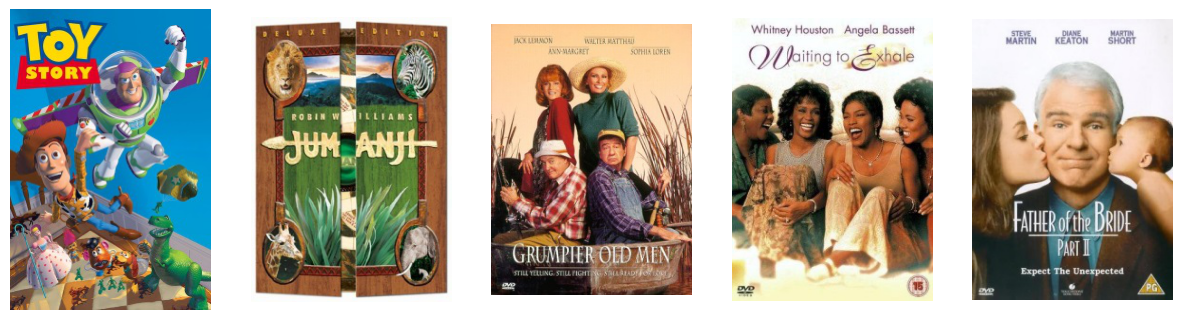

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Fetch images
movie_list = movies_metadata['imdb_id'].head(5).values

images = image_url(movie_list)

show_image(images)

# Keywords Embedding Recommendation

In [15]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import ast


def keyword_similarity(keywords):
    # Load a fast sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast!

    # Convert string representation of list to actual list
    keywords["keywords"] = keywords["keywords"].apply(ast.literal_eval)

    # Extract only the 'name' values
    keywords["keywords_list"] = keywords["keywords"].apply(lambda x: [d["name"] for d in x] if isinstance(x, list) else [])

    keywords['keywords_list'] = keywords['keywords_list'].apply(lambda x: ' '.join(x))

    # Encode movie keywords into embeddings
    keywords['vector'] = keywords['keywords_list'].apply(lambda x: model.encode(x))

    # Stack vectors for similarity computation
    movie_vectors = np.vstack(keywords['vector'].values)

    keyword_similarity_matrix = cosine_similarity(movie_vectors)

    return keyword_similarity_matrix

def keyword_rec(matrix, keywords, merge_df, movie, top_n = 10):
    keywords = keywords.merge(merge_df, left_on='id', right_on='tmdbId', how='left')
    movie_index = dict(zip(np.unique(keywords["movieId"]), list(range(keywords.shape[0]))))
    index_movie = dict(zip(list(range(keywords.shape[0])), np.unique(keywords["movieId"])))

    idx= movie_index[movie]
    similar_movies = list(enumerate(matrix[idx]))
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:top_n+1]
    similar_movie_list = [index_movie[i[0]] for i in similar_movies]

    # Fetch images
    movie_list = merge_df[merge_df['movieId'].isin(similar_movie_list)]['imdb_id'].values

    return movie_list

In [73]:
# keywords = keywords.merge(links, left_on='id', right_on='tmdbId', how='left')
# movie_index = dict(zip(np.unique(keywords["movieId"]), list(range(keywords.shape[0]))))
# index_movie = dict(zip(list(range(keywords.shape[0])), np.unique(keywords["movieId"])))

# movie = 1
# idx= movie_index[movie]
# top_n=5

# similar_movies = list(enumerate(keyword_similarity_matrix[idx]))
# similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:top_n+1]
# similar_movie_list = [index_movie[i[0]] for i in similar_movies]

# # Fetch images
# movie_list = merged_df[merged_df['movieId'].isin(similar_movie_list)]['imdb_id'].values

In [ ]:
keyword_similarity_matrix = keyword_similarity(keywords)
movie_list = keyword_rec(keyword_similarity_matrix, keywords, merged_df, 1, 10)

images = image_url(movie_list)
show_image(images)

NameError: name 'merged_df' is not defined

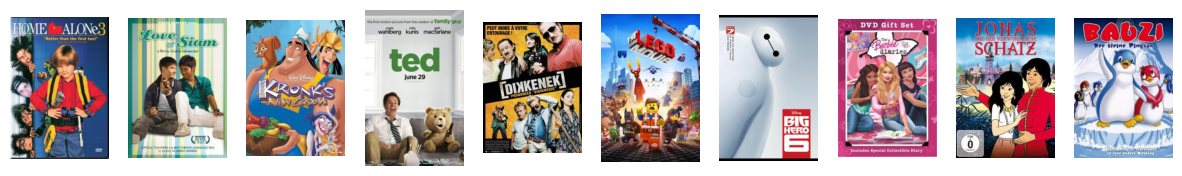

# item-item recommendations with k-nn 
### Create user x movie matrix on ratings
**What movies were rated similarly by users?**

In [21]:
from scipy.sparse import csr_matrix
import numpy as np

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """

    # Number of unique users and movies to form matrix
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    # Map user/movie ID to an index (id, index)
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    # Map an index to a user/movie ID (index,id)
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    # list of unique indexes for users and movies
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    
    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [22]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    # Now it is movie x user by transposing it.
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

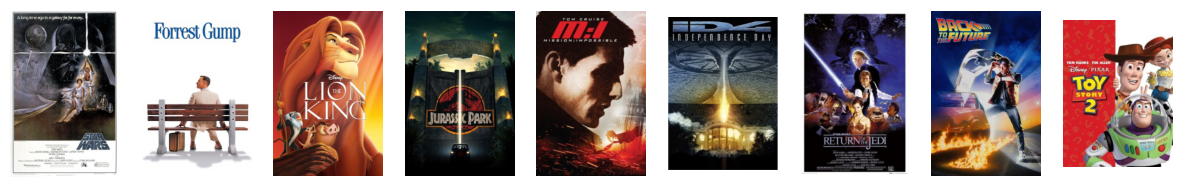

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

search = 1
similar_movies = find_similar_movies(search, X, movie_mapper, movie_inv_mapper, k=10)

# Fetch images
movie_list = merged_df[merged_df['movieId'].isin(similar_movies)]['imdb_id'].values

images = image_url(movie_list)
show_image(images)

# Purely based on genre
### One hot encoded movie x genre

In [25]:
import ast

def genre_rec(merged_df, movie, top_n = 10):
    # Convert string representation of list to actual list
    merged_df["genres"] = merged_df["genres"].apply(ast.literal_eval)

    # Extract only the 'name' values
    merged_df["genres_list"] = merged_df["genres"].apply(lambda x: [d["name"] for d in x] if isinstance(x, list) else [])

    genres = set(g for G in merged_df["genres_list"] for g in G)
    df = merged_df[['movieId','genres_list']]

    for g in genres:
        df[g] = df.genres_list.transform(lambda x: int(g in x))

    df = df.reset_index(drop=True)
    movie_mapper = dict(zip(list(range(df.shape[0])), df["movieId"]))
    mapper_movie = dict(zip(df["movieId"], list(range(df.shape[0]))))
    movie_genres = df.drop(columns=['genres_list','movieId'])

    cosine_sim = cosine_similarity(movie_genres, movie_genres)

    idx = mapper_movie[movie]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(top_n+1)]
    similar_movies = [movie_mapper[i[0]] for i in sim_scores]

    return similar_movies

In [93]:

# # Convert string representation of list to actual list
# merged_df["genres"] = merged_df["genres"].apply(ast.literal_eval)

# # Extract only the 'name' values
# merged_df["genres_list"] = merged_df["genres"].apply(lambda x: [d["name"] for d in x] if isinstance(x, list) else [])

# genres = set(g for G in merged_df["genres_list"] for g in G)
# test = merged_df[['movieId','genres_list']]

# for g in genres:
#     test[g] = test.genres_list.transform(lambda x: int(g in x))

# test = test.reset_index(drop=True)
# movie_mapper = dict(zip(list(range(test.shape[0])), test["movieId"]))
# mapper_movie = dict(zip(test["movieId"], list(range(test.shape[0]))))
# movie_genres = test.drop(columns=['genres_list','movieId'])

# from sklearn.metrics.pairwise import cosine_similarity

# cosine_sim = cosine_similarity(movie_genres, movie_genres)
# print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

# movie = 1
# idx = mapper_movie[movie]

# n_recommendations=10
# sim_scores = list(enumerate(cosine_sim[idx]))
# sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
# sim_scores = sim_scores[1:(n_recommendations+1)]
# similar_movies = [movie_mapper[i[0]] for i in sim_scores]

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_3044\1731236273.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[g] = df.genres_list.transform(lambda x: int(g in x))
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_3044\1731236273.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[g] = df.genres_list.transform(lambda x: int(g in x))
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_3044\1731236273.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


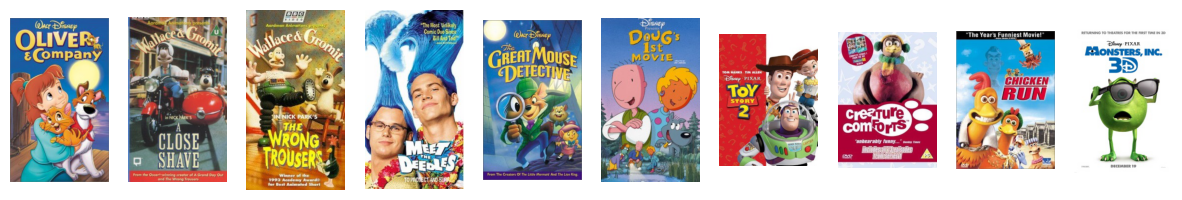

In [26]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Fetch images

similar_movies = genre_rec(merged_df, 1)

movie_list = merged_df[merged_df['movieId'].isin(similar_movies)]['imdb_id'].values

images = image_url(movie_list)

show_image(images)

# Users with similar taste also watch

In [118]:
search_user = 1
similar_users = find_similar_movies(search_user, X.T, user_mapper, user_inv_mapper, k=10)

original_user = ratings[ratings['userId'] == 1]['movieId'].unique()

similar_recommend = pd.DataFrame(
    ratings[
        (ratings['userId'].isin(similar_users)) & (~ratings['movieId'].isin(original_user))
    ]['movieId'].unique(), 
    columns=["movieId"]
)

In [119]:
import pandas as pd

# Global mean rating (m)
global_mean = ratings["rating"].mean()

# Number of ratings per movie (n)
movie_counts = ratings.groupby("movieId")["rating"].count()

# Total rating sum per movie
movie_rating_sums = ratings.groupby("movieId")["rating"].sum()

# C: Average number of ratings per movie
C = movie_counts.mean()

# Compute Bayesian Mean for each movie
bayesian_mean_ratings = (movie_rating_sums + global_mean * C) / (movie_counts + C)

# Store results
bayesian_mean_df = bayesian_mean_ratings.reset_index().rename(columns={"rating": "bayesian_mean"})


bayesian_mean_df = bayesian_mean_df.merge(merged_df[['movieId','title']], on='movieId',how='left')

similar_recommend.merge(bayesian_mean_df, on='movieId',how='left').sort_values(by='bayesian_mean',ascending=False).head(20)

,movieId,bayesian_mean,title
55,318,4.423345,The Shawshank Redemption
50,50,4.292747,The Usual Suspects
63,1193,4.219194,One Flew Over the Cuckoo's Nest
67,1213,4.167437,GoodFellas
49,296,4.165790,Pulp Fiction
21,79132,4.151567,Inception
6,2571,4.149500,The Matrix
51,593,4.147993,The Silence of the Lambs
3,1196,4.136842,The Empire Strikes Back
72,2329,4.134574,American History X


In [123]:
merged_df[merged_df['movieId'].isin(original_user)]['title']

108                                        Braveheart
144                            The Basketball Diaries
835                                     The Godfather
1181                           The Godfather: Part II
1204                               Dead Poets Society
1863                               The Breakfast Club
2652                                  The Sixth Sense
2807                         Ferris Bueller's Day Off
2848                                       Fight Club
4104                                          Memento
4755                                     Donnie Darko
5450                                   Igby Goes Down
10138                                   Batman Begins
12004                                        Superbad
12501                                 The Dark Knight
12608                                        Iron Man
13669                                       Star Trek
13919          Harry Potter and the Half-Blood Prince
14586                       

# New Releases

In [125]:
temp = merged_df[pd.to_datetime(merged_df['release_date']) >= pd.to_datetime('2017-07-01')][['movieId','release_date']].sort_values(by='release_date',ascending=False)
release_ratings = ratings.merge(merged_df[['movieId','release_date']], on='movieId')
recent_release = release_ratings[pd.to_datetime(release_ratings['release_date']) >= pd.to_datetime('2017-07-01')]
recent_release["time_weight"] = (recent_release["timestamp"] - recent_release["timestamp"].min()) / (recent_release["timestamp"].max() - recent_release["timestamp"].min())

# Apply an exponential decay function (e.g., exp(weight) to give more importance to recent_release recent_release)
recent_release["time_weight"] = np.exp(recent_release["time_weight"])


In [92]:
# Weighted sum of ratings per movie
weighted_rating_sums = recent_release.groupby("movieId").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))

# Weighted count (sum of weights per movie)
weighted_counts = recent_release.groupby("movieId")["time_weight"].sum()

# Adjusted global mean with weighted ratings
weighted_global_mean = np.sum(recent_release["rating"] * recent_release["time_weight"]) / np.sum(recent_release["time_weight"])


# Number of ratings per movie (n)
movie_counts = recent_release.groupby("movieId")["rating"].count()

C = movie_counts.mean()

# Compute Bayesian Mean with time-adjusted weighting
time_weighted_bayesian_mean = (weighted_rating_sums + weighted_global_mean * C) / (weighted_counts + C)

# Store results
time_weighted_bayesian_recent_release = time_weighted_bayesian_mean.reset_index().rename(columns={0: "time_weighted_bayesian_mean"})

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_16256\1477845222.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_rating_sums = recent_release.groupby("movieId").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))


In [93]:
a = list(time_weighted_bayesian_recent_release.sort_values(by='time_weighted_bayesian_mean', ascending=False)['movieId'].head(20))
merged_df[merged_df['movieId'].isin(a)]['title']

26831                                  Thor: Ragnarok
33859                                 Pitch Perfect 3
41654                                     London Town
42894    Science Fiction Volume One: The Osiris Child
43276                               God's Own Country
44106                                  Beyond Skyline
44987                  War for the Planet of the Apes
45391                                         Dunkirk
45470                             Resurrecting Hassan
45493                                    A Gray State
45588                                            Dina
45619                                       Good Time
45721                                           78/52
45886                        The Nile Hilton Incident
45889                                     Shot Caller
45899                           S.W.A.T.: Under Siege
45915                                          Zygote
45921                                         Detroit
46114                Thick L

# Currently Trending

In [79]:
ratings.sort_values(by='date',ascending=False)

,userId,movieId,rating,timestamp,date
19445749,201926,3752,3.0,1501827001,2017-08-04
5201411,53582,3873,3.0,1501821956,2017-08-04
6047168,62283,7153,4.5,1501820528,2017-08-04
17322160,179793,111659,3.5,1501808799,2017-08-04
17322159,179793,111443,4.5,1501808890,2017-08-04
...,...,...,...,...,...
4402347,45491,24,3.0,822873600,1996-01-29
3662481,38150,1176,4.0,789652004,1995-01-09
4313905,44717,21,3.0,789652009,1995-01-09
4313911,44717,47,5.0,789652009,1995-01-09


In [64]:
ratings["date"] = pd.to_datetime(ratings["timestamp"], unit="s").dt.date


recent = ratings[ratings['date'] >= pd.Timestamp("2017-07-01").date()]


In [65]:
recent

,userId,movieId,rating,timestamp,date
20964,237,50,5.0,1499226562,2017-07-05
20965,237,593,4.0,1499226585,2017-07-05
20966,237,2762,4.0,1499226620,2017-07-05
20967,237,2959,4.0,1499226582,2017-07-05
20968,237,48780,4.5,1499226614,2017-07-05
...,...,...,...,...,...
26023511,270887,170645,4.0,1499826010,2017-07-12
26023512,270887,170705,0.5,1500920343,2017-07-24
26023514,270887,170913,0.5,1500918216,2017-07-24
26023517,270887,171439,1.0,1500925554,2017-07-24


In [66]:
recent["time_weight"] = (recent["timestamp"] - recent["timestamp"].min()) / (recent["timestamp"].max() - recent["timestamp"].min())

# Apply an exponential decay function (e.g., exp(weight) to give more importance to recent recent)
recent["time_weight"] = np.exp(recent["time_weight"])

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_16256\2355790361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["time_weight"] = (recent["timestamp"] - recent["timestamp"].min()) / (recent["timestamp"].max() - recent["timestamp"].min())
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_16256\2355790361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["time_weight"] = np.exp(recent["time_weight"])


In [68]:
recent.sort_values(by='date',ascending=False)

,userId,movieId,rating,timestamp,date,time_weight
18962106,196893,6539,4.0,1501819406,2017-08-04,2.708698
473753,4916,4096,2.5,1501815646,2017-08-04,2.705262
6047128,62283,3911,4.0,1501820375,2017-08-04,2.709584
6047127,62283,3863,3.0,1501820405,2017-08-04,2.709611
6047126,62283,3785,4.5,1501820656,2017-08-04,2.709841
...,...,...,...,...,...,...
18148606,188391,135534,3.0,1498926072,2017-07-01,1.020070
18148593,188391,130686,3.0,1498926108,2017-07-01,1.020082
18148592,188391,130684,3.0,1498926527,2017-07-01,1.020226
18148577,188391,122884,3.0,1498926057,2017-07-01,1.020065


In [69]:
# Weighted sum of ratings per movie
weighted_rating_sums = recent.groupby("movieId").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))

# Weighted count (sum of weights per movie)
weighted_counts = recent.groupby("movieId")["time_weight"].sum()

# Adjusted global mean with weighted ratings
weighted_global_mean = np.sum(recent["rating"] * recent["time_weight"]) / np.sum(recent["time_weight"])


# Number of ratings per movie (n)
movie_counts = recent.groupby("movieId")["rating"].count()

C = movie_counts.mean()

# Compute Bayesian Mean with time-adjusted weighting
time_weighted_bayesian_mean = (weighted_rating_sums + weighted_global_mean * C) / (weighted_counts + C)

# Store results
time_weighted_bayesian_recent = time_weighted_bayesian_mean.reset_index().rename(columns={0: "time_weighted_bayesian_mean"})

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_16256\24627695.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_rating_sums = recent.groupby("movieId").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))


In [71]:
a = list(time_weighted_bayesian_recent.sort_values(by='time_weighted_bayesian_mean', ascending=False)['movieId'].head(20))
merged_df[merged_df['movieId'].isin(a)]['title']

289                                 Leon: The Professional
292                                           Pulp Fiction
314                               The Shawshank Redemption
835                                          The Godfather
1135                                       Cinema Paradiso
1164                                          12 Angry Men
1173                                            GoodFellas
1914                                         Seven Samurai
2848                                            Fight Club
3347                                          Modern Times
5489                                         Spirited Away
17013                                Louis C.K.: Hilarious
17018                                Louis C.K.: Shameless
20156                                             Paperman
25310                                      Song of the Sea
29055    Berserk: The Golden Age Arc 2 - The Battle for...
39796                                         Planet Ear

# Best alltime

In [ ]:
import pandas as pd

# Global mean rating (m)
global_mean = ratings["rating"].mean()

# Number of ratings per movie (n)
movie_counts = ratings.groupby("movieId")["rating"].count()

# Total rating sum per movie
movie_rating_sums = ratings.groupby("movieId")["rating"].sum()

# C: Average number of ratings per movie
C = movie_counts.mean()

# Compute Bayesian Mean for each movie
bayesian_mean_ratings = (movie_rating_sums + global_mean * C) / (movie_counts + C)

# Store results
bayesian_mean_df = bayesian_mean_ratings.reset_index().rename(columns={"rating": "bayesian_mean"})

a = list(bayesian_mean_df.sort_values(by='bayesian_mean', ascending=False)['movieId'].head(20))


In [52]:
merged_df[merged_df['movieId'].isin(a)]['title']

49                                      The Usual Suspects
292                                           Pulp Fiction
314                               The Shawshank Redemption
522                                       Schindler's List
733      Dr. Strangelove or: How I Learned to Stop Worr...
835                                          The Godfather
879                                            Rear Window
883                                     North by Northwest
887                                             Casablanca
1155                       One Flew Over the Cuckoo's Nest
1164                                          12 Angry Men
1172                                         The Third Man
1173                                            GoodFellas
1181                                The Godfather: Part II
1914                                         Seven Samurai
2848                                            Fight Club
5489                                         Spirited Aw